<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 10. Бустинг
## <center>Часть 5. Оценка важности признаков с Xgboost

## Загрузка бибилиотек

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font_scale=1.5)
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Загрузка и подготовка данных

Посмотрим на примере данных по оттоку клиентов из телеком-компании.### Load data<a name='data' />

In [2]:
df = pd.read_csv("../../data/telecom_churn.csv")

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Штаты просто занумеруем, а признаки International plan (наличие международного роуминга), Voice mail plan (наличие голосовой почтыы) и целевой Churn сделаем бинарными.**

In [4]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])
df["International plan"] = (df["International plan"] == "Yes").astype("int")
df["Voice mail plan"] = (df["Voice mail plan"] == "Yes").astype("int")
df["Churn"] = (df["Churn"]).astype("int")

**Разделим данные на обучающую и тестовую выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dtest.**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Churn", axis=1),
    df["Churn"],
    test_size=0.3,
    stratify=df["Churn"],
    random_state=17,
)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

### Обучение модели

**Обучим всего 50 деревьев решений глубины 3.**

In [6]:
params = {"objective": "binary:logistic", "max_depth": 3, "silent": 1, "eta": 0.5}

num_rounds = 50

In [7]:
watchlist = [(dtest, "test"), (dtrain, "train")]  # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[15:27:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	test-logloss:0.44114	train-logloss:0.42330
[1]	test-logloss:0.34620	train-logloss:0.31389
[2]	test-logloss:0.29674	train-logloss:0.25487
[3]	test-logloss:0.27432	train-logloss:0.21883
[4]	test-logloss:0.24807	train-logloss:0.19157
[5]	test-logloss:0.23248	train-logloss:0.17364
[6]	test-logloss:0.23101	train-logloss:0.16601
[7]	test-logloss:0.22841	train-logloss:0.15963
[8]	test-logloss:0.22418	train-logloss:0.15506
[9]	test-logloss:0.22110	train-logloss:0.14670
[10]	test-logloss:0.22245	train-logloss:0.14267
[11]	test-logloss:0.22189	train-loglo

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


### Важность признаков

**F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

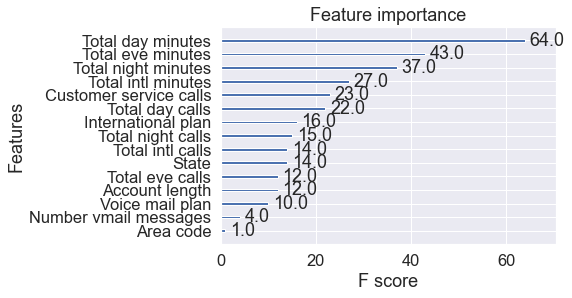

In [8]:
xgb.plot_importance(xgb_model);

**Можно так, в виде словаря или DataFrame:**

In [9]:
importances = xgb_model.get_fscore()
importances

{'State': 14.0,
 'Account length': 12.0,
 'Area code': 1.0,
 'International plan': 16.0,
 'Voice mail plan': 10.0,
 'Number vmail messages': 4.0,
 'Total day minutes': 64.0,
 'Total day calls': 22.0,
 'Total eve minutes': 43.0,
 'Total eve calls': 12.0,
 'Total night minutes': 37.0,
 'Total night calls': 15.0,
 'Total intl minutes': 27.0,
 'Total intl calls': 14.0,
 'Customer service calls': 23.0}

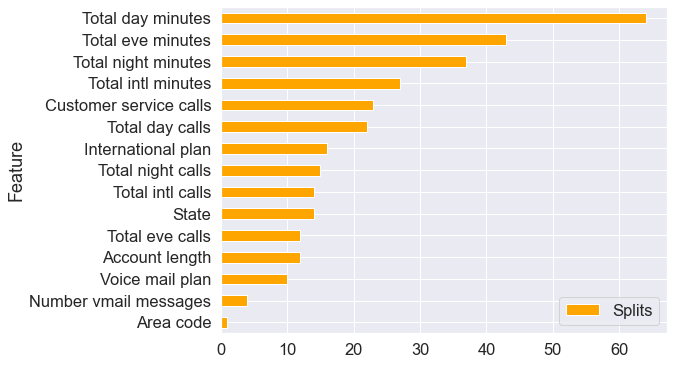

In [10]:
# create df
importance_df = pd.DataFrame(
    {"Splits": list(importances.values()), "Feature": list(importances.keys())}
)
importance_df.sort_values(by="Splits", inplace=True)
importance_df.plot(kind="barh", x="Feature", figsize=(8, 6), color="orange");